In [1]:
from platform import python_version

print(python_version())


3.8.5


In [62]:
pip install numba

You should consider upgrading via the '/home/darrenyeo/python/python/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from tqdm.notebook import tqdm

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
from scipy import constants

#Marius:
from tqdm import tqdm
import numba

In [61]:
#Global variables
L = 10 #unit:nm length of the box
N = 100#100 #unit:numbers
m = 39.948 # unit: a.m.u
T = 100 #unit:kelvin
KB = constants.R*10**-3  #unit KJ/mol.K
dt = 10**-3 #unit:ps
n_steps =10000 #unitness
epsilon = 1
sigma = 0.34
tauT = 0.1 #Coupling constant for the Berendsen thermostat #ps, tau referenced online for 0.1-0.4 ps for dt of 1fs(femtosecond)
tauP = 5 #Pressure coupling constant for Berendsen Barostat

In [6]:
def write_file(FILE1, coords, n_iter):
    
    '''
    
    This function is used to save obtained coordinates into the PyMol readable format PDB.
    It also writes several other interesting stuff to plain .txt files.
    
    FILE1 := Coordinaten File Name (Should end with .pdb)
    n_iter := Number of step
    
    '''


    #Coordinates are round to the second decimal position to faciliate saving
    round_ = 2

    #Write head for each frame   
    FILE1.write('MODEL {}\n'.format(n_iter)) #Start of a frame
    N = coords.shape[0] #Get number of atoms
    
    
    #Just iterate over all coordinates and write them down line per line
    for i in range(N):
        
        #The PDB-formate is really strict the line below is from: https://cupnet.net/pdb-format/
 
        #ATOM  #ID   #NAME     #RESN      #RESID          #X    #Y     #Z
        coord_str = "{:6s}{:5d} {:^4s}{:1s}{:3s} {:1s}{:4d}{:1s}   {:8.3f}{:8.3f}{:8.3f}{:6.2f}{:6.2f}          {:>2s}{:2s}\n".format('ATOM', int(i),
                                                                                                                         'PAR', ' ', 'ARG',
                                                                                                                         ' ', int(i), ' ',
                                                                                                                         np.round(coords[i][0], round_)*10,
                                                                                                                         np.round(coords[i][1], round_)*10,
                                                                                                                         np.round(coords[i][2], round_)*10,
                                                                                                                          1.0, 1.0, 'Ar', ' ')
 
 
        FILE1.write(coord_str) #Write coordinates
    FILE1.write('TER\nENDMDL\n') #End of a frame

# Position / Velocity init

In [7]:
def init_pos():
    """initialize position of atoms within L in x, y, z coordinates where L = 2
    Border and grid set to be "smaller" than the box size where L = 2 """
   
    coord =[]
    border= 2*sigma # no atoms will generate that are <2*sigma
    Grid = (L-border) # no atoms will generate that are > L-(2*sigma)
    
    #Here the problem was that you could have the same positions. We fixed that with an if-statement and a while loop.
    
    while len(coord) < N: 
        
        coordinates = [np.random.choice(np.arange(border,Grid,0.1)), np.random.choice(np.arange(border,Grid,0.1)), np.random.choice(np.arange(border,Grid,0.1))]
        
        if not coordinates in coord: coord.append(coordinates)

    return np.array(coord)

In [8]:
def init_vel():
    """initialize random velocities of the atoms"""
    
    velocity = np.random.normal(0, np.sqrt(KB*T/m),(N,3)) #Cleaned up some variable names!
    
    return velocity

In [9]:
def hist_plot(file_name, vels):
    fig, ax = plt.subplots(2,2)
    y_axes = ['Freq', 'Freq', 'Freq', 'Prob density']
    x_axes = ['Vx', 'Vy', 'Vz', 'V']
    title =['Hist Vx', 'Hist Vy', 'Hist Vz', 'Maxwell boltzman distribution']
    c=0
    for i in range(2):
        for j in range(2):
            if c !=3:
                
                ax[i,j].hist(vels[:,c], bins =20, density=True)
                ax[i,j].set_title(title[c])
                ax[i,j].set_xlabel(x_axes[c])
                ax[i,j].set_ylabel(y_axes[c])
            else:
                ax[i,j].hist(np.sqrt(np.sum(vel**2, 1)), bins =20, density=True)
                ax[i,j].set_title(title[c])
                ax[i,j].set_xlabel(x_axes[c])
                ax[i,j].set_ylabel(y_axes[c])
                    
            c+=1
    plt.tight_layout()
            
        


# Test atoms for algorithms

In [10]:
def test_pos():
    """For testing of the different boundaries"""
    pos = np.array([[1,5,5], [0.6,5,5]])
    
    return pos

In [11]:
def test_vel():
    """For testing of the different boundaries"""
    vel = np.array([[0,0,0], [0,0,0]])
    
    return vel


# Defining Boundaries and initialization of force

In [12]:
def no_bounds(pos, vel):
    """BOUNDARY CONDITION for wall potential"""
    return pos, vel

In [13]:
#def compute_force(pos): # initialised to zero at the beginning of the simulation-- will increase later
#    """set forces to 0"""
#    pos = np.zeros((N,3))
#    return np.zeros(pos.shape)

#-> Test case for non-interacting particles! We don't need anymore

In [115]:
def pbc(pos, vel, L): 
    pos = np.where(pos>0, pos ,L+pos) #for all positions of atoms bigger than 0, stay as it is. otherwise plus L to be in the box 
    pos = np.where(pos<L, pos, pos-L) #for all positions of atoms smaller than L, stay as it is. otherwise minus L to be in the box
    
    #helps to prevent atoms from flying away
    mean =np.zeros(3)
    counter =0
    for vec in vel:
        mean +=vec
        counter +=1
    mean /= counter
    vel -=mean
    
    return pos, vel

In [20]:
def Angle(pos, vel):
    """Boundary where particles bounces off the wall at an angle"""
    for i in range(N):
        for j in range(3):
            if pos[i,j]<0:
                pos[i,j] = pos[i,j]*(-1) #When particles in x, y, z coodrinates outside of the "box", pos<0. angle reflection has to be same
                vel[i,j]=  vel[i,j]*(-1)
                
            elif pos[i,j]>L:
                pos[i,j] = 2*L-pos[i,j] #When particles in x, y, z coodrinates outside of the "box", pos>L. angle reflection has to be same
                vel[i,j]=  vel[i,j]*(-1)
                
    return pos, vel

In [19]:
def wall_force(pos):
    """Wall potential repulsion (F) according to lennard jones potential, only the repulsion part of the equation is taken into account"""
    
    force = np.zeros((N,3))
    for i in range(N):
        for j in range(3):
            if pos[i,j]<(4*sigma):
                force[i,j] = 48*(epsilon/sigma)*((sigma/(np.absolute(pos[i,j]))**13))
                
                
                
            elif pos[i,j]>(L-(4*sigma)):
                force[i,j] = -48*(epsilon/sigma)*((sigma/(L-pos[i,j]))**13) #- sign, because the force needs to be in the negative direction as it repels from the right side of the box
                
                
    return force   

# Temperature and pressure coupling

In [21]:
def temp(vel):
    """Returns the current temperature of the system"""
    #KE = e_kin(vel)
    #temp = 2*KE*N/3*KB -> We changed it to below line
    
    temp = (m * np.sum(vel**2)) / (3 * N * KB)
    
    
    return temp
    

In [22]:
def berendsen_temp(vel):
    """Berendsen thermostat"""
    
    temp_new = temp(vel)
    scale = np.sqrt(1+(dt/tauT)*(T/temp_new-1))
    
    
    return scale 

In [116]:
def pressure_coupling(P):
    """Berendsen Barostat"""
    B=1.8*(10**4)
    P0 = 1
    scale = (1 +(dt / tauP) * B * (P0 - P) )**(1/3)
    #scale = (1 - 1/ KB* dt / tauP * (P0 - P) )**(1/3)
    
    return scale

In [89]:
pressure_coupling(P)

NameError: name 'P' is not defined

# Algorithms

In [24]:
def Euler(pos, vel, boundary):
    """Euler algorithm, kraft frei"""
    pos_new = pos+ vel*dt
    pos_new, vel_new =boundary(pos_new, vel)       
        
    
    
    return pos_new

In [25]:
def Verlet(pos, pos_old, vel, force, boundary):
    """Verlet algorithm"""
    force = Interacting_atoms(pos) 
    #force = force + wall_force(pos) #+In order to implement wall potential
    pos_new = 2*pos - pos_old + force/m * dt**2
    vel = ((pos_new  - pos_old)/2*dt)
    pos_new, vel_new =boundary(pos_new, vel)
    
    return pos_new, pos, vel_new

In [26]:
#def Velocity_verlet(pos, vel, boundary):
 #   """Initial Velocity Verlet for pbc and angle reflection"""
 #   force = Force(pos)
 #   pos_new = pos + vel*dt + (force/(2*m))*dt**2 
 #   force_new = Force(pos_new)
 #   vel_new = vel + ((force_new + force)/(2*m))*dt
 #   pos_new =boundary(pos_new)
    
 #   return pos_new, vel_new

In [27]:
def Velocity_verlet(pos, vel, boundary, L):
    """Velocity Verlet to run with Wall boundary repulsion according to lennard jones potential.
    Only repulsion is taken into account. Interaction of atoms according to LJ included"""
    #force = compute_force(pos) + wall_force(pos) #when computing forces
    force, P = Interacting_atoms(pos, L, NL)

    scale = berendsen_temp(vel) ##Scale value for berendsen thermostat
    
    scale_P =pressure_coupling(P)#Scale value for berendsen barostat
    
    #Scaling of temperature coupling
    vel = scale*vel
    
    #Scaling of box size
    pos= scale_P*pos
    L=scale_P*L
    
    pos_new = pos + vel*dt + (force/(2*m))*dt**2  # Veleocity verlet algorithm for position
    #force_new = compute_force(pos_new) + wall_force(pos_new)
    force_new, P = Interacting_atoms(pos_new, L, NL)

    

    vel_new = vel + ((force_new + force)/(2*m))*dt # Veleocity verlet algorithm for velocity



    pos_new, vel_new =boundary(pos_new, vel_new, L)

    return pos_new, vel_new, P


In [28]:
#def Leapfrog(pos, vel, boundary):
#    """Leapfrog algorithm"""
#    force = Interacting_atoms(pos) #when computing forces, this will not be correct
#    #force = compute_force(pos) + wall_force(pos) # in order to implement wall_force repulsion   
#    vel_new = vel + dt*(force/m)
#    pos_new = pos + dt*vel_new
#    pos_new, vel_new =boundary(pos_new, vel_new)
    #print(force)
    
#    return pos_new, vel_new


In [113]:
def Leapfrog(pos, vel, boundary, L, NL):
    """Leapfrog algorithm"""
    force, P = Interacting_atoms(pos, L, NL) #when computing forces, this will not be correct
    #force = compute_force(pos) + wall_force(pos) # in order to implement wall_force repulsion   
    
    
    
    #1) Generate new velocities based on old (correct) velocities
    vel_new = vel + dt*(force/m)
    
    #2) Calculate scaling factor for new (uncorrected) velocities and box size
    scale = berendsen_temp(vel_new) #Scale value for berendsen thermostat
    scale_P =pressure_coupling(P)
    
    #3) Apply scaling to new velocities
    vel_new = scale*vel_new #scale value taken into account
    
    #4)Appy scaling to box size
    pos = scale_P * pos
    L= scale_P *L

    
    #5) Make new positions
    pos_new = pos + dt*vel_new
    
    pos_new, vel_new = boundary(pos_new, vel_new, L)
    #print(force)
    
    return pos_new, vel_new, P, L


In [30]:
@numba.jit(nopython = True, fastmath = True)
def get_positions(pos1, pos2):
    """Return der direction of r and the absolute value of r (Distance)"""

    r_vector = (pos1 - pos2) # positions in x,y,z coordinates
    
    if r_vector[0] > L/2:
        r_vector[0] = r_vector[0] -L
    elif r_vector[0] < -L/2:
        r_vector[0] = L + r_vector[0]
    
    if r_vector[1] > L/2:
        r_vector[1] = r_vector[1] -L
    elif r_vector[1] < -L/2:
        r_vector[1] = L + r_vector[1]
        
    if r_vector[2] > L/2:
        r_vector[2] = r_vector[2] -L
    elif r_vector[2] < -L/2:
        r_vector[2] = L + r_vector[2]
        
        
    absolute_r = (np.sqrt(r_vector[0]**2 + r_vector[1]**2 +r_vector[2]**2)) #obtain the absolute positions of r 
    
    return r_vector, absolute_r

# Energy calculation of the system

In [31]:
def e_kin(vel):
    """Return the kinetic enery of the system"""
    
    KE = np.sum(1/2*m*vel**2)
    
    return KE

In [32]:
def e_pot(pos):
    """Function that calculate the potential energy according to LJ potential"""
    PE =0
    for i in range(N):
        for j in range(N):
            
            if i <= j:
                continue
    
            else:
                r_vector, absolute_r = get_positions(pos[i],pos[j])
                
                PE = PE + 4*epsilon*((sigma/absolute_r)**12 - (sigma/absolute_r)**6)
    
    return PE

In [33]:
def total_energy(pos, vel):
    """Total energy of the system from KE and PE"""
    
    TE = e_kin(vel) + e_pot(pos) #Removed np.sum -> Redundant
    
    
    return TE
    

In [95]:
def Interacting_atoms(pos, L, NL):
    """function that describes interaction between atoms according to LJ potential (Force)"""
    
    
    #Think about the for-loop -> Can you skip half of the calculations?
    #Hint: Your potential energy function
    
    Rc_force = 1 #nm
    force = np.zeros((N,3))
    dV_sum = 0
    P=0
    for i in range(N): # Loop over all atoms
        for j in range(N): #Loop over all other atoms (interacting atoms)
            if i == j: #Skip self forces
                continue
            else: #sum of all forces where i != to J
            
                
                r_vector, absolute_r = get_positions(pos[i],pos[j]) #calling the get_positions function to calculate force between two atoms (i and j) index representing each atom in i and each atom in 
       
                if absolute_r <= Rc_force:
            
                    dV = 24*(epsilon/sigma)*(2*((sigma/(absolute_r))**13)-(sigma/(absolute_r))**7)
                
                
                    for k in range(3):
                        force[i,k] += dV*r_vector[k]/absolute_r#compute force to each particle
                        
                    dV_sum += dV * r_vector[k]
                    
    
    
    #Pressure calculation
    vol = L**3

    P += (1/vol)*(N*KB*T-1/3*(dV_sum))/6.022*100 # prefactor of avogrado constant multplied by 100, converts units to bar

                #Force_vector = negative derivative of potential * r_vector/absolute value of r, where r = distance between two atoms
            
    
    return force, P       

Right now you are having a neighbour list with a cut-off value. However, we want to implement a **buffer**. Therefore, you need 2 cut-off values. The one which is already there (Rc/Neighbour list) and a smaller one in the force calculation (Interacting_atoms). Why?

# Neighbor List

In [35]:
@numba.jit(nopython = True, fastmath = True)
def Neighbor_list(pos):
    """omits atoms in the simulation when they are too far away 
    to save computing time. Atoms that too far away are determined by
    the cut off value."""
    Rc = 1.2  #Cut off value radius of i, units nm
    neighbors=[]
    for i in range(N):
        list_2 =[]
        for j in range(N):
            if i==j: #Skip self forces
                continue
            
            
            else:
                r_vector, absolute_r = get_positions(pos[i],pos[j])
                
                if absolute_r < Rc:
                    list_2.append(j)
        
        neighbors.append(list_2.copy())
    
    return neighbors
                         

# Main function

In [114]:
def main(mode, L):
   
    pos=init_pos()
    vel=init_vel()
    #pos=test_pos()
    #vel=test_vel()
    
    file_name=open("read.pdb", "w")
    file_name.write('CRYST1'+str("{0:9.3f}{0:9.3f}{0:9.3f}").format(L*10,L*10,L*10)+'  90.00  90.00  90.00 P 1           1\n')
    write_file(file_name, pos, 0)
    
    if mode == 0:
        """Run euler algorithm"""
        for n_iter in range(n_steps):
            pos=Euler(pos, vel, pbc)
            if n_iter%50 ==0:
                write_file(file_name, pos, n_iter)
            KE = e_kin(vel)
            
            
    if mode == 1:
        """Run verlet algorithm"""
        dist_atoms = []
        PE =[]
        KE =[]
        TE =[]
        pos_old = pos
        pos = Euler(pos, vel, pbc)
        for n_iter in tqdm(range(n_steps)):
            force=Interacting_atoms(pos)
            #force=compute_force(pos)
            #force+=wall_force(pos)
            pos, pos_old, vel=Verlet(pos, pos_old, vel, force, pbc)
            #pos, pos_old=Verlet(pos, pos_old, vel, force, no_bounds)
            if n_iter%50 ==0:
                NL = Neighbor_list(pos)
                write_file(file_name, pos, n_iter)
                
            dist_atoms.append(get_positions(pos[0], pos[1])[1])
            PE.append(e_pot(pos))
            KE.append(e_kin(vel))
            TE.append(total_energy(pos, vel))
            
            
            
    if mode == 2:
        """Run verlocity verlet algorithm"""
        dist_atoms = []
        PE =[]
        KE =[]
        TE =[]
        Temp =[]
        Pressure =[]
        NL = Neighbor_list(pos) #initial list to be updated in the loop
        for n_iter in tqdm(range(n_steps)):
            pos, vel, P= Velocity_verlet(pos, vel, pbc, L)            
            #pos, vel = Velocity_verlet(pos, vel, no_bounds) #no_bounds to implement wall_force boundary. 
            if n_iter%10 ==0:
                NL = Neighbor_list(pos)
                write_file(file_name, pos, n_iter)
                
                
            dist_atoms.append(get_positions(pos[0], pos[1])[1])
            PE.append(e_pot(pos))
            KE.append(e_kin(vel))
            TE.append(total_energy(pos, vel))
            Temp.append(temp(vel))
            Pressure.append(P)
            
            
            
    
    if mode == 3:
        """Run leapfrog algorithm"""
        dist_atoms = []
        PE =[]
        KE =[]
        TE =[]
        Temp =[]
        Pressure =[]
        NL = Neighbor_list(pos) #initial list to be updated in the loop
        for n_iter in tqdm(range(n_steps)):
            pos, vel, P, L= Leapfrog(pos, vel, pbc, L, NL)
            #pos, vel = Leapfrog(pos, vel, no_bounds) #to implement wall_force boundary
            if n_iter%10 ==0:
                NL = Neighbor_list(pos)
                write_file(file_name, pos, n_iter)
            

            dist_atoms.append(get_positions(pos[0], pos[1])[1])
            PE.append(e_pot(pos))
            KE.append(e_kin(vel))
            TE.append(total_energy(pos, vel))
            Temp.append(temp(vel))
            Pressure.append(P)
            
            
            
            
            
            
    file_name.close()
    return dist_atoms, PE, KE, TE, NL, Temp, Pressure

# Leapfrog

In [49]:
N = 300
dist_atoms, PE, KE, TE, NL, Tem, Pres= main(3, L)
#main(3)


100%|██████████| 1000/1000 [03:54<00:00,  4.26it/s]


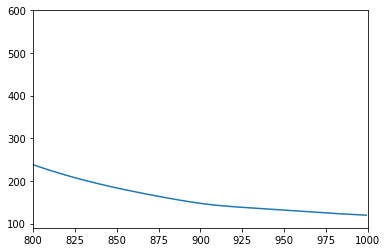

In [52]:
plt.ylim((90,600))
plt.xlim((800,1000))
plt.plot(Tem)

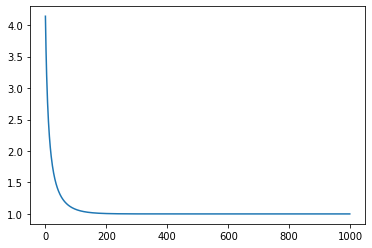

In [53]:
plt.plot(Pres)

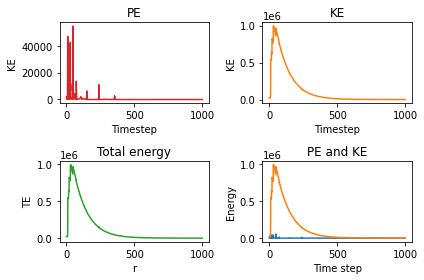

In [54]:
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(PE, 'tab:red')
axs[0, 0].set_title('PE')
axs[0, 0].set_xlabel('Timestep')
axs[0, 0].set_ylabel('KE')

axs[0, 1].plot(KE, 'tab:orange')
axs[0, 1].set_title('KE')
axs[0, 1].set_xlabel('Timestep')
axs[0, 1].set_ylabel('KE')

axs[1, 0].plot(TE, 'tab:green') # spikes in the total energy at 10^-3 timestep 
axs[1, 0].set_title('Total energy')
axs[1, 0].set_xlabel('r')
axs[1, 0].set_ylabel('TE')

axs[1, 1].plot(PE,'tab:blue')
axs[1, 1].plot(KE, 'tab:orange')
axs[1, 1].set_title('PE and KE')
axs[1, 1].set_xlabel('Time step')
axs[1, 1].set_ylabel('Energy')

plt.tight_layout()

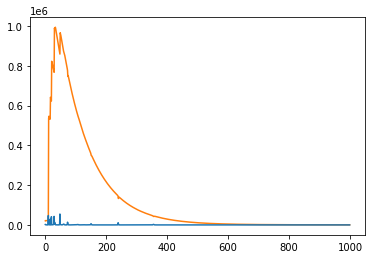

In [55]:
plt.plot(KE,'tab:orange')
plt.plot(PE,'tab:blue')

## LF 100

In [ ]:
N = 50
dist_atoms, PE, KE, TE, NL, Tem, Pres= main(3, L)
#main(3)

  5%|▍         | 459/10000 [00:04<01:41, 94.19it/s]<ipython-input-95-305e461d5d1e>:35: RuntimeWarning: overflow encountered in double_scalars
  vol = L**3
 12%|█▏        | 1209/10000 [00:12<01:33, 94.29it/s]

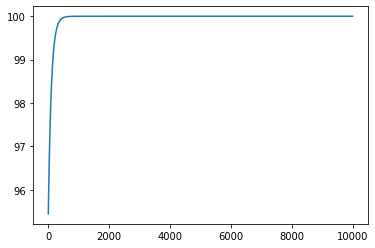

In [108]:
#plt.ylim((0.99,1.1))
#plt.xlim((3000,10000))
plt.plot(Tem)

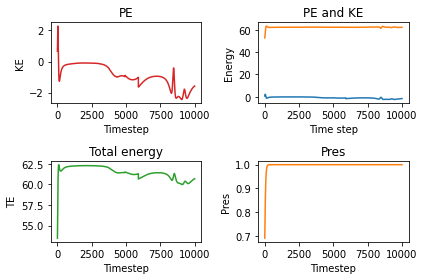

In [102]:
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(PE, 'tab:red')
axs[0, 0].set_title('PE')
axs[0, 0].set_xlabel('Timestep')
axs[0, 0].set_ylabel('KE')

axs[0, 1].plot(PE,'tab:blue')
axs[0, 1].plot(KE, 'tab:orange')
axs[0, 1].set_title('PE and KE')
axs[0, 1].set_xlabel('Time step')
axs[0, 1].set_ylabel('Energy')

axs[1, 0].plot(TE, 'tab:green') # spikes in the total energy at 10^-3 timestep 
axs[1, 0].set_title('Total energy')
axs[1, 0].set_xlabel('Timestep')
axs[1, 0].set_ylabel('TE')

axs[1, 1].plot(Pres, 'tab:orange')
axs[1, 1].set_title('Pres')
axs[1, 1].set_xlabel('Timestep')
axs[1, 1].set_ylabel('Pres')

plt.tight_layout()

In [ ]:
#Without Numba: Est. time for 700 particles: 02:56:33 ~0.099 it/s
#With Numba: Est. time for 700 particles: 00:13:32 ~ 1.17 it/s

#Conclusion: It is worth trying Numba!